# Problem 1
Modify the classes AdalineGD and LogisticRegressionGD in the textbook such that the bias
data field b is absorbed by the weight vector w . Your program is required to be compatible with the training
programs in the textbook.

In [2]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')


In [3]:
class AdalineGD(object):
    """
    ADApative LInear NEuron Classifier
    Params: 
    eta (float) : Learning rate (between 0.0 and 1.0)
    n_iter (int) : Number of passes over the training dataset.
    random_state (int) : Random number generator seed for random weight initialization.

    Attrs:
    w_ (1d-array) : Weights after fitting.
    cost_ (list) : Sum-of-squares cost function value in each epoch.
    """
    def __init__(self, eta=0.01, n_inter=50, random_state=1):
        self.eta = eta
        self.n_inter = n_inter
        self.random_state = random_state
    def fit(self, X, y):
        """
        Fitting Training Data
        Params:
        X {array-like}, shape = [n_examples, n_features]
        Training vectors, where n_examples is the number of examples and n_features is the number of features.
        y (array-like) ,shape = [n_examples]
        Target values.

        Returns:
        self : Object
        """
        n = X.shape[0] #number of samples
        m = X.shape[1] #number of features in dataset
        x_0 = np.ones((n,1))
        X = np.hstack((x_0,X))
        
        rand_gen = np.random.RandomState(self.random_state)
        self.w_ = rand_gen.normal(loc=0.0, scale=0.01,
                                  size=1 + m) #small random numbers
                                              #drawn from a normal distrib.
                                              #with std dev 0.01
        self.cost_ = []

        for _ in range(self.n_inter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_  += self.eta * X.T.dot(errors)
            
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)

        return self
    def net_input(self, X):
        """Calculate net input"""
        #return np.dot(X, self.w_[1:]) + self.w_[0]
        return np.dot(X, self.w_)

    def activation(self, X):
        """Computer Linear Activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        n = X.shape[0] 
        m = X.shape[1] #number of features in dataset
        x_0 = np.ones((n,1))
        X = np.hstack((x_0,X))
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

In [4]:
class LogisticRegressionGD(object):
    """
    Gradient descent-based logistic regression classifier
    Params: 
    eta (float) : Learning rate (between 0.0 and 1.0)
    n_iter (int) : Number of passes over the training dataset.
    random_state (int) : Random number generator seed for random weight initialization.

    Attrs:
    w_ (1d-array) : Weights after fitting with bias absorbed at X[0].
    losses_ (list) : Mean squared error loss function values in each epoch.
    """
    def __init__(self, eta=0.01, n_inter=50, random_state=1):
        self.eta = eta
        self.n_inter = n_inter
        self.random_state = random_state
    def fit(self, X, y):
        """
        Fitting Training Data
        Params:
        X {array-like}, shape = [n_examples, n_features]
        Training vectors, where n_examples is the number of examples and n_features is the number of features.
        y (array-like) ,shape = [n_examples]
        Target values.

        Returns:
        self : Instance of LogisticRegressionGD
        """
        n = X.shape[0] 
        m = X.shape[1] #number of features in dataset
        x_0 = np.ones((n,1))
        X = np.hstack((x_0,X))

        
        rand_gen = np.random.RandomState(self.random_state)
        self.w_ = rand_gen.normal(loc=0.0, scale=0.01,
                                  size=1 + m) #m + 1 to account for the
                                              #absorbed bias
        
        self.losses_ = []
        print("unique y:", np.unique(y))
        print("min/max y:", y.min(), y.max())
        print("dtype y:", y.dtype)

        for _ in range(self.n_inter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_  += self.eta * X.T.dot(errors) / n
            #eps = 1e-10
            #p = np.clip(output, eps, 1 - eps)
            #loss = (-y.dot(np.log(p)) - (1 - y).dot(np.log(1 - p))) / X.shape[0]
            loss = (-y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
                   )/ n
            self.losses_.append(loss)

        return self
    def net_input(self, X):
        """Calculate net input"""
        #return np.dot(X, self.w_[1:]) + self.w_[0]
        return np.dot(X, self.w_)

    def activation(self, X):
        """Computer Linear Activation"""
        return 1. / (1. + np.exp(-np.clip(X, -250, 250)))

    def predict(self, X):
        """Return class label after unit step"""
        n = X.shape[0]
        m = X.shape[1] #number of features in dataset
        x_0 = np.ones((n,1))
        X = np.hstack((x_0,X))
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)
        

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_decision_regions(X,y, classifier, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    #plot the decision surface
    x1_min, x1_max = X[:,0].min() - 1, X[:,0].max() + 1
    x2_min, x2_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))

    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    #plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl,0],
                    y = X[y==cl,1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl,
                    edgecolor='black')

In [6]:
s = os.path.join('https://archive.ics.uci.edu', 'ml',
                 'machine-learning-databases',
                 'iris','iris.data')
print('URL:', s)
df = pd.read_csv(s,
                 header=None,
                 encoding='utf-8')
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/'
                      'wine/wine.data',
                       header=None,
                       encoding='utf-8')

#select setosa and versicolor
y1 = df.iloc[0:100, 4].values
y1 = np.where(y1 == 'Iris-setosa', -1, 1)
y2 = df_wine.iloc[0:100, 0]
y2 = np.where(y2 == 2, 1, -1)

#extract sepal length and petal length
X1 = df.iloc[0:100, [0,2]].values
X2 = df_wine.iloc[0:100, [1,2]].values

URL: https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data


In [7]:
#standarize
X_std1 = np.copy(X1)
X_std1[:,0] = (X1[:,0] - X1[:,0].mean()) / X1[:,0].std()
X_std1[:,1] = (X1[:,1] - X1[:,1].mean()) / X1[:,1].std()
#standarize
X_std2 = np.copy(X2)
X_std2[:,0] = (X2[:,0] - X2[:,0].mean()) / X2[:,0].std()
X_std2[:,1] = (X2[:,1] - X2[:,1].mean()) / X2[:,1].std()

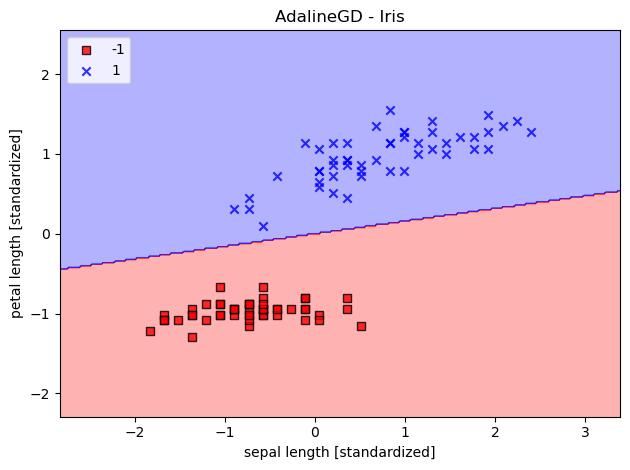

In [8]:
ada_gd = AdalineGD(n_inter=10000, eta=0.01)
ada_gd.fit(X_std1, y1)

plot_decision_regions(X_std1, y1, classifier=ada_gd)
plt.title('AdalineGD - Iris')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

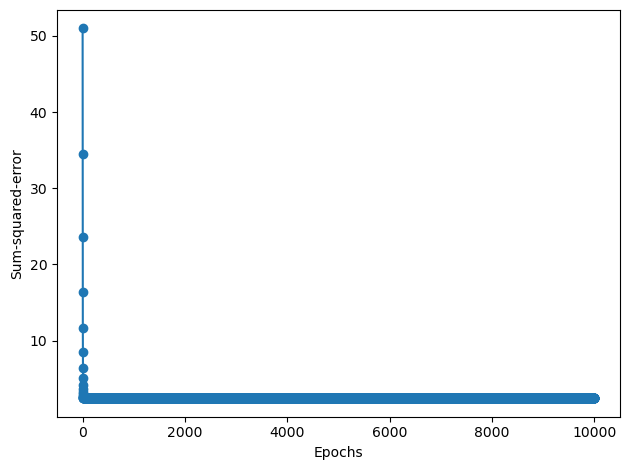

In [9]:
plt.plot(range(1, len(ada_gd.cost_) + 1),
         ada_gd.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.tight_layout()
plt.show()

In [10]:
s = os.path.join('https://archive.ics.uci.edu', 'ml',
                 'machine-learning-databases',
                 'iris','iris.data')

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/'
                      'wine/wine.data',
                       header=None,
                       encoding='utf-8')
print('URL:', s)

df = pd.read_csv(s,
                 header=None,
                 encoding='utf-8')

#select setosa and versicolor
y1 = df.iloc[0:100, 4].values
y1 = np.where(y1 == 'Iris-setosa', 0, 1)
y2 = df_wine.iloc[0:100, 0]
y2 = np.where(y2 == 2, 1, 0)

#extract sepal length and petal length
X1 = df.iloc[0:100, [0,2]].values
X2 = df_wine.iloc[0:100, [1,2]].values

URL: https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data


unique y: [0 1]
min/max y: 0 1
dtype y: int64


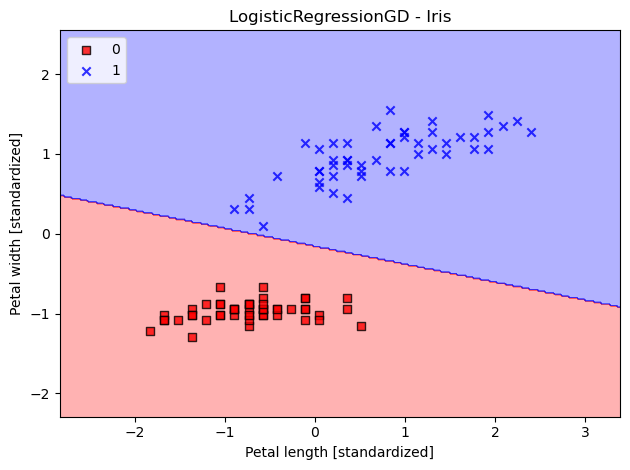

In [11]:
lrgd = LogisticRegressionGD(eta=0.01,
                             n_inter=10000,
                             random_state=1)
lrgd.fit(X_std1, y1)
plot_decision_regions(X_std1, y1, classifier=lrgd)

plt.title('LogisticRegressionGD - Iris')
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

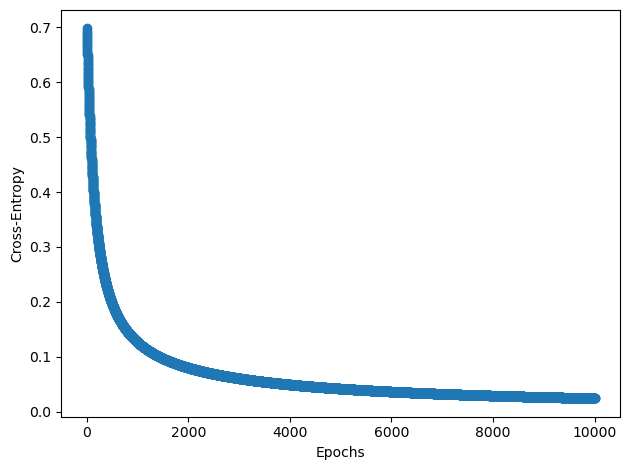

In [12]:
plt.plot(range(1, len(lrgd.losses_) + 1),
         lrgd.losses_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.tight_layout()
plt.show()

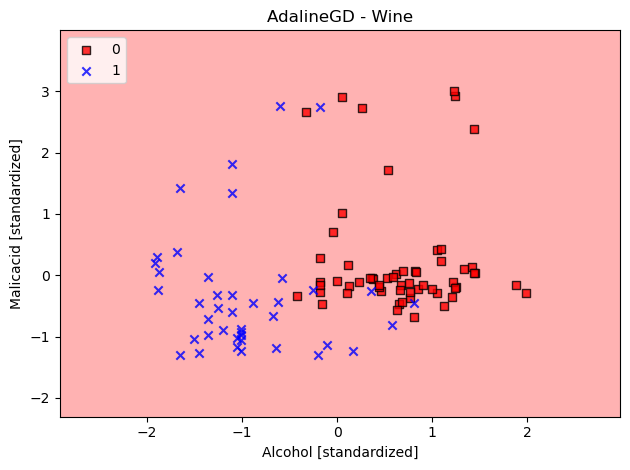

In [13]:
ada_gd2 = AdalineGD(n_inter=1000, eta=0.1)
ada_gd2.fit(X_std2, y2)

plot_decision_regions(X_std2, y2, classifier=ada_gd2)
plt.title('AdalineGD - Wine')
plt.xlabel('Alcohol [standardized]')
plt.ylabel('Malicacid [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

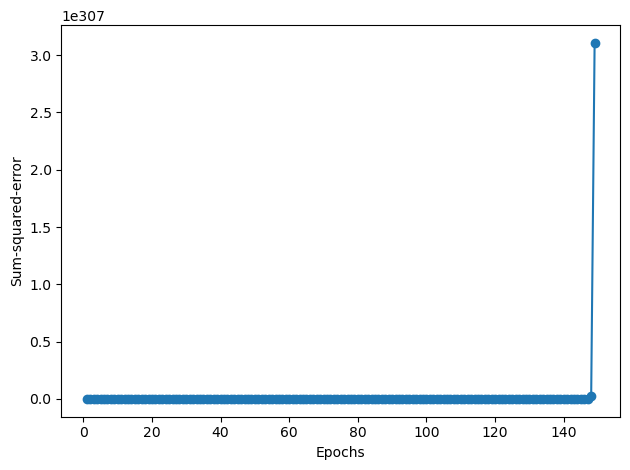

In [14]:
plt.plot(range(1, len(ada_gd2.cost_) + 1),
         ada_gd2.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.tight_layout()
plt.show()

unique y: [0 1]
min/max y: 0 1
dtype y: int64


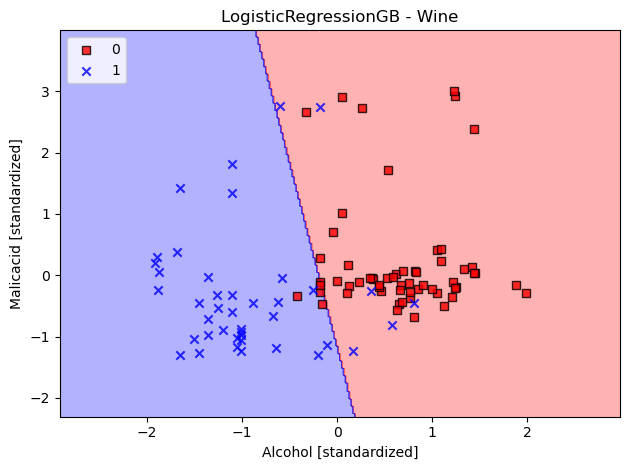

In [15]:
lrgd2 = LogisticRegressionGD(eta=0.1,
                             n_inter=1000,
                             random_state=1)
lrgd2.fit(X_std2, y2)
plot_decision_regions(X_std2, y2, classifier=lrgd2)

plt.title('LogisticRegressionGB - Wine')
plt.xlabel('Alcohol [standardized]')
plt.ylabel('Malicacid [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

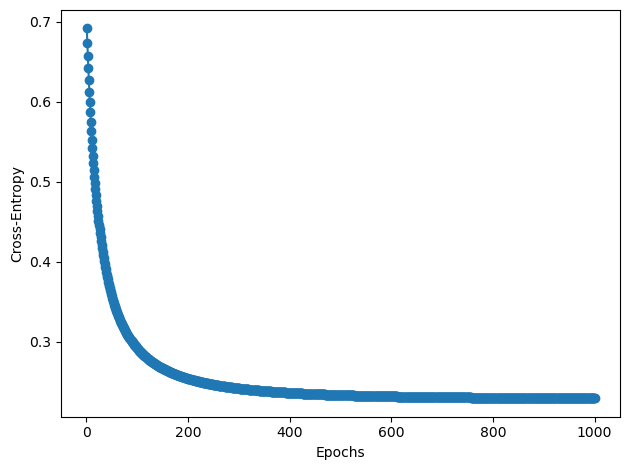

In [16]:

plt.plot(range(1, len(lrgd2.losses_) + 1),
         lrgd2.losses_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.tight_layout()
plt.show()

# ANSWER 1 WOULD GO HERE

# Problem 2
Compare the performance of Adaline and logistic regression (bias absorbed versions) on the Iris
and Wine datasets that can be obtained from the UCI machine learning repository. You may use the Python
program given in our textbook (Page 117) to import the datasets.
- Iris dataset - You may consider the samples with the labels setosa, versicolor to form a training set for binary classification.
- Wine dataset - You may consider the samples with in the first two classes (1 and 2) to form a training set for binary classification.

The comparisons should be done based on the convergence of the loss. In order to make apple-to-apple comparisons, you should use the same hyperparameters and number of epochs for both learning algorithms.

# ANSWER 2 WOULD GO HERE

# Problem 3

In [21]:
# %% [markdown]
# # Perceptron
# Nathan Nail, CS 429 Spring 2026
# 
# This code is adapted from the course's textbook. 
# 
# 

# %%
# perceptron.py
# Nathan Nail - CS 429 Spring 2026

# creates a perceptron classifier. 

import numpy as np

class Perceptron:
    """
    Docstring for Perceptron

    Hyperparameters:
    eta: a float representing the learning rate. 

    n_iter: Number of epochs to run through. 

    random_state: An integer used as the seed for the 
    random state generator. Initializes small values for
    best performance to prevent overcorrecting. 
    
    If all weights were 0, all will have the same error. 
    "Broken symmetry" allows for algorithm to work. 

    Attributes:
    Indicated with a _ afterwards as part of naming convention (how?
    to what end?)

    w_: vector of weights as a 1D array.

    b_: Scalar int, bias unit. 

    errors_: a list 
    Number of misclassifications in each epoch. 
    """
    def __init__(self, eta = 0.01, n_iter = 50, random_state = 1):

        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    def fit(self, X, y):
        """
        Fitting Training Data
        Params:
        X {array-like}, shape = [n_examples, n_features]
        Training vectors, where n_examples is the number of examples and n_features is the number of features.
        y (array-like) ,shape = [n_examples]
        Target values.

        Returns:
        self : Object
        """
        m = X.shape[1] #number of features in dataset
        rand_gen = np.random.RandomState(self.random_state)
        self.w_ = rand_gen.normal(loc=0.0, scale=0.01,
                                  size=1 + m) #small random numbers
                                              #drawn from a normal distrib.
                                              #with std dev 0.01
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0 
            for xi, target in zip(X,y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update #w_[0] is the bias
                errors+= int(update != 0.0)
            self.errors_.append(errors)
        return self
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

In [22]:
"""
Docstring for multiclass

This implementation uses a one-vs-many approach, where different perceptrons are used. 
- One perceptron per iris class
- Modify true outputs such that the correct species is 1 and the two incorrect species are 0. 
- 

"""

class Multiclass():
    """
    Docstring for MultiPerceptron
    """

    def __init__(self):
        self.setosa_neuron = Perceptron(n_iter=1000)
        self.versicolor_neuron = Perceptron(n_iter=1000)
        self.virginica_neuron = Perceptron(n_iter=1000)
    def fit(self, X, y):
        self.setosa_neuron.fit(X,np.where(y == 0,  1, -1))
        self.versicolor_neuron.fit(X,np.where(y == 1,  1, -1))
        self.virginica_neuron.fit(X,np.where(y == 2,  1, -1))
        return self
    def predict(self, X):
        c = np.column_stack([self.setosa_neuron.predict(X),
                             self.versicolor_neuron.predict(X),
                             self.virginica_neuron.predict(X)])

        predicted = np.zeros(X.shape[0])
        for i in (range(X.shape[0])):
            best_value = c[i,0]
            best_label = 0
            for j in (range(c.shape[1])):
                if c[i,j] > best_value:
                    best_value = c[i,j]
                    best_label = j
            predicted[i]= best_label
        return predicted
        #return np.argmax(c, axis=1)

In [23]:
mc = Multiclass()

# read data from data file
data = pd.read_csv("data/iris.data", header=None, encoding='utf-8') 
# print(data.tail())

# find feature matrix and true class labels from data
X_4 = data.iloc[:, [2, 3]].to_numpy()
Y_ref = data.iloc[:, 4].to_numpy()

Y_ref = np.where(Y_ref == 'Iris-setosa',0,Y_ref)
Y_ref = np.where(Y_ref == 'Iris-versicolor',1,Y_ref)
Y_ref = np.where(Y_ref == 'Iris-virginica',2,Y_ref)

print(Y_ref)
#print(Y_versicolor.shape)
print("X_4 shape:", X_4.shape)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
X_4 shape: (150, 2)


In [24]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
def plot_decision_regions_(X, y, classifier, test_idx=None,
                          resolution=0.02):
    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')
    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]
        
        plt.scatter(X_test[:, 0], X_test[:, 1],
                    c='none', edgecolor='black', alpha=1.0,
                    linewidth=1, marker='o',
                    s=100, label='Test set')

In [25]:
X_std4 = np.copy(X_4)
X_std4[:,0] = (X_4[:,0] - X_4[:,0].mean()) / X_4[:,0].std()
X_std4[:,1] = (X_4[:,1] - X_4[:,1].mean()) / X_4[:,1].std()

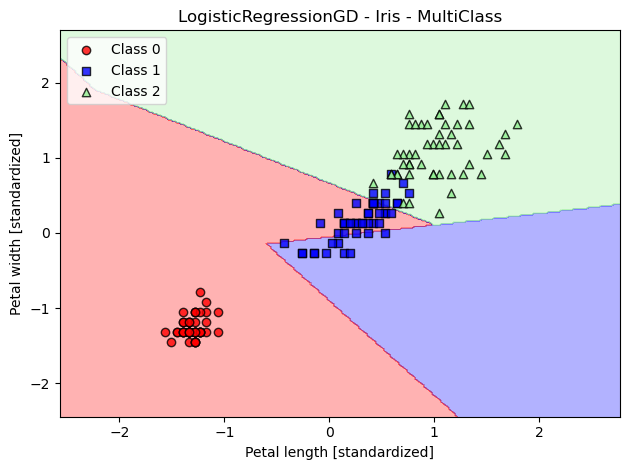

In [26]:
mc.fit(X_std4, Y_ref)
plot_decision_regions_(X_std4, Y_ref, classifier=mc)

plt.title('LogisticRegressionGD - Iris - MultiClass')
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Answer 3 goes here...

# Problem 4

In [29]:
# p4: minibatch_SGD

# %% [markdown]
# # Logistic Regression
# Nathan Nail - CS 429 Fall 2026
# 
# **NOTE** this model also uses gradient descent. 



# %%
import numpy as np
import pandas as pd
import os

class LogisticRegressionGD:
    """
    Logistic regression (a classifier model) using GD to converge to 
    a solution. 

    Parameters:
    ------
    eta: learning rate
    n_iter: number of epochs
    random_state: int seeding the RNG. 
    batch_size: int representing the size of each minibatch. 

    Attributes
    ----------
    w_: 1D array containing the weights after training. 
    b_: Scalar value of the bias unit. 
    losses: A list containing the MSE loss values for each epoch. 
    """

    def __init__(self, eta = 0.01, n_iter = 50, random_state=1, batch_size = 32):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        self.batch_size = batch_size

    # %% [markdown]
    # ### Fit the model
    # 
    # NOTE: np.T transposes the matrix. 

    """
    mini-batch workflow:
    - use a list comprehension to make a nested list. A list containing n batches. 
    - determine the batch size.
    for **each** epoch:
    - shuffle the data
    - create batches of specified size 
    - train on the batches, adjusting the model for each batch

    a reshuffle and new rebatching is required for each epoch. 
    """
    def fit_mini_batch_sgd(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc = 0.00, scale = 0.01, size = X.shape[1])
        self.b_ = np.float64(0.)
        self.losses = []
    
        n_batches = int(np.ceil(X.shape[0] / self.batch_size))

        # list containing n_batches number of mini-batches. 
        num_lists = [[] for i in range(n_batches)]
        batch_Xs = np.ndarray((n_batches, self.batch_size, X.shape[1]))
        batch_Ys = np.ndarray((n_batches, self.batch_size))

    

        for i in range(self.n_iter):

            num_losses = 0

            # create a shuffled list of indices. 
            idx_list = np.arange(X.shape[0])
            np.random.shuffle(idx_list)

            # make the mini_batches by pulling from X and Y. 
            for i in range(self.batch_size - 1):                                # repeat _batchsize_ number of times
                for list_num in range(n_batches - 1):                          # for each list:
                    np.append(batch_Xs[list_num], X[idx_list[list_num + i]])     # place a value from X into a minibatch.
                    np.append(batch_Ys[list_num], y[idx_list[list_num + i]])

            for i in range(n_batches):
                net_input = self.net_input(batch_Xs[i])
                output = self.activation(net_input)
                # adjust sizing to batch size. 
                errors = batch_Ys[i] - output
                self.w_ += self.eta * 2.0 * batch_Xs[i].T.dot(errors)
                self.b_ += self.eta * 2.0 * errors.mean()
                loss = (-batch_Ys[i].dot(np.log(output)) - ((1-batch_Ys[i]).dot(np.log(1-output)))) / batch_Xs.shape[0]
                num_losses += loss
                
            self.losses.append(loss)

        # TODO add in per-epoch error tracking. 

        print(self.losses)
        return self
# %%
    def net_input(self, X):
        """
        Calculate the net input.
        """
        return np.dot(X, self.w_) + self.b_


    def activation(self, z):
        """
        Logistic sigmoid activation
        
        :param self: A reference to this class
        :param z: the output. 
        """
        # 1. makes 1 a float
        return 1. /  (1./ + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        # predict in class 1 if the log. sig. returns over the 0.5 threshold. 
        return np.where(self.activation(self.net_input(X) >= 0.5, 1, 0))

In [30]:
minibatchSGD = LogisticRegressionGD(0.01, 50, 1, 32)
iris_data = pd.read_csv("data/iris.data")

print(iris_data.tail())

X = iris_data.iloc[:, 0:3].to_numpy()
y = iris_data.iloc[:, 4].to_numpy()

for i in range(len(y)):
    if (y[i] == "Iris-setosa"):
        y[i] = int(0)
    elif (y[i] == "Iris-versicolor"):
        y[i] = int(1)
    else:  # virginica
        y[i] = int(2)

print(X[146:150])
print(y[146:150])

minibatchSGD.fit_mini_batch_sgd(X, y)

     5.1  3.5  1.4  0.2     Iris-setosa
144  6.7  3.0  5.2  2.3  Iris-virginica
145  6.3  2.5  5.0  1.9  Iris-virginica
146  6.5  3.0  5.2  2.0  Iris-virginica
147  6.2  3.4  5.4  2.3  Iris-virginica
148  5.9  3.0  5.1  1.8  Iris-virginica
[[6.5 3.  5.2]
 [6.2 3.4 5.4]
 [5.9 3.  5.1]]
[2 2 2]
[3.0625808753339372e+259, 3.0625808753339372e+259, 3.0625808753339372e+259, 3.0625808753339372e+259, 3.0625808753339372e+259, 3.0625808753339372e+259, 3.0625808753339372e+259, 3.0625808753339372e+259, 3.0625808753339372e+259, 3.0625808753339372e+259, 3.0625808753339372e+259, 3.0625808753339372e+259, 3.0625808753339372e+259, 3.0625808753339372e+259, 3.0625808753339372e+259, 3.0625808753339372e+259, 3.0625808753339372e+259, 3.0625808753339372e+259, 3.0625808753339372e+259, 3.0625808753339372e+259, 3.0625808753339372e+259, 3.0625808753339372e+259, 3.0625808753339372e+259, 3.0625808753339372e+259, 3.0625808753339372e+259, 3.0625808753339372e+259, 3.0625808753339372e+259, 3.0625808753339372e+259, 3.062

Answer 4 goes here...